#Download and extract data.

In [0]:
#!wget https://www.dropbox.com/s/8cia5dodmhf1do0/UCMerced_LandUse.zip

In [0]:
#!unzip UCMerced_LandUse.zip

#Data exploration

We have 21 different classes. For each class, we have 100 images. All images are RGB and 256x256 pixels.

In [0]:
import os

PATH = './dataset/Images/'
cats = os.listdir(PATH)
cats, len(cats)

(['airplane',
  'runway',
  'golfcourse',
  'agricultural',
  'mediumresidential',
  'mobilehomepark',
  'river',
  'tenniscourt',
  'parkinglot',
  'overpass',
  'freeway',
  'denseresidential',
  'chaparral',
  'harbor',
  'storagetanks',
  'buildings',
  'sparseresidential',
  'forest',
  'intersection',
  'baseballdiamond',
  'beach'],
 21)

In [0]:
#for cat in cats:
#  cnt = !ls {PATH}/{cat} | wc -l 
#  print(cat, cnt)

In [0]:
import pandas as pd

imgs, labs = [], []
for ix, cat in enumerate(cats):
  _imgs = os.listdir(PATH+cat)
  imgs += [cat+'/'+_img for _img in _imgs]
  labs += [ix for _img in _imgs]
df = pd.DataFrame({'img_name': imgs, 'label': labs})
df.sample(5)

,img_name,label
720,tenniscourt/tenniscourt50.tif,7
401,mediumresidential/mediumresidential59.tif,4
51,airplane/airplane70.tif,0
2017,beach/beach77.tif,20
1379,harbor/harbor28.tif,13


((256, 256, 3), 'sparseresidential')

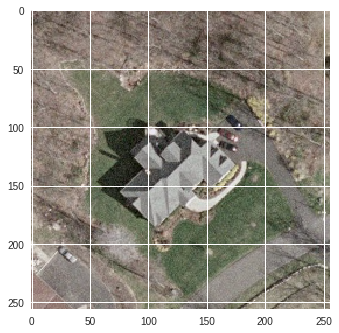

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

ix = random.randint(0, len(df)-1)
img = Image.open(PATH+df.img_name.values[ix])
img = np.array(img)
plt.imshow(img)
img.shape, cats[df.label.values[ix]]

In [0]:
from sklearn.model_selection import train_test_split

df_t, df_v = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df.label)
len(df_t), len(df_v)

(1680, 420)

In [0]:
#df_t.hist(bins=21)
#df_v.hist(bins=21)

# Dataset

We define our dataset so when a new element is requested an image is loaded, resized to 224x224 pixels (input size for Resnet), transposed (Pytorch requires dimensions #channels x height x width), normalized (divide by 255) and transformed to a tensor. 

Then we define our dataloader to load images in batches.

In [0]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, path, imgs, labs):
    self.path = path
    self.imgs = imgs
    self.labs = labs
    
  def __len__(self):
    return len(self.labs)
    
  def __getitem__(self, ix):
    img, lab = self.imgs[ix], self.labs[ix]
    img = Image.open(self.path+self.imgs[ix]).resize((224,224))
    img = np.array(img)
    img = torch.FloatTensor(img.transpose((2,0,1)) / 255)
    return img, lab

In [0]:
dataset = {
    'train': MyDataset(PATH, df_t.img_name.values, df_t.label.values),
    'val': MyDataset(PATH, df_v.img_name.values, df_v.label.values)
}

(torch.Size([3, 224, 224]), 'mediumresidential')

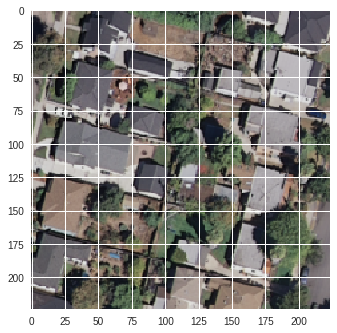

In [0]:
ds = dataset['train']
ix = random.randint(0, len(ds)-1)
img, lab = ds[ix]
plt.imshow(img.numpy().transpose((1,2,0)))
img.shape, cats[lab]

In [0]:
from torch.utils.data import DataLoader

bs = 32
dataloader = {
    'train': DataLoader(dataset['train'], batch_size=bs, num_workers=4, shuffle=True),
    'val': DataLoader(dataset['val'], batch_size=bs, num_workers=4, shuffle=False)
}


# Model

We will use a Resnet18 and replace the fully connected layer with a custom head to match our problem.

In [0]:
from model import Model

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Model(len(cats))
net.to(device)

input = torch.randn((16,3,224,224))
output = net(input.to(device))
output.shape

cuda:0


torch.Size([16, 21])

# Training

In [0]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [0]:
from tqdm import tqdm

epochs = 30
best = 0
for e in range(epochs):
  # train
  net.train()
  losses = []
  for imgs, labs in tqdm(dataloader['train']):
    output = net(imgs.to(device))
    loss = criterion(output, labs.to(device))
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # eval
  net.eval()
  val_losses, acc = [], []
  for imgs, labs in tqdm(dataloader['val']):
    output = net(imgs.to(device))
    labs = labs.to(device)
    loss = criterion(output, labs)
    val_losses.append(loss.item())
    _, preds = torch.max(output.data, 1)
    correct = (preds == labs).sum().item() / labs.size(0)
    acc.append(correct)
  # keep best model
  acc = np.mean(acc)
  if acc > best:
    best = acc
    torch.save(net.state_dict(), 'best_state_dict.pth')
    print("Best model with acc ", acc)
  # print statistics
  print()
  print('Epoch: {}/{}. Train loss: {:.4f}, Val loss: {:.4f}, Acc: {:.4f}'.format(e+1, epochs, np.mean(losses), np.mean(val_losses), acc))
print("Best model saved with acc ", acc)

  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.6785714285714286

Epoch: 1/30. Train loss: 2.2191, Val loss: 1.3886, Acc: 0.6786


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.8415178571428571

Epoch: 2/30. Train loss: 1.0822, Val loss: 0.8351, Acc: 0.8415


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.8616071428571429

Epoch: 3/30. Train loss: 0.7143, Val loss: 0.6346, Acc: 0.8616


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.8861607142857143

Epoch: 4/30. Train loss: 0.5471, Val loss: 0.5041, Acc: 0.8862


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.8950892857142857

Epoch: 5/30. Train loss: 0.4408, Val loss: 0.4514, Acc: 0.8951


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 6/30. Train loss: 0.3771, Val loss: 0.4253, Acc: 0.8862


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 7/30. Train loss: 0.3371, Val loss: 0.3771, Acc: 0.8929


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 8/30. Train loss: 0.3046, Val loss: 0.3729, Acc: 0.8906


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.9040178571428571

Epoch: 9/30. Train loss: 0.2484, Val loss: 0.3321, Acc: 0.9040


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.9241071428571429

Epoch: 10/30. Train loss: 0.2376, Val loss: 0.2992, Acc: 0.9241


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 11/30. Train loss: 0.2111, Val loss: 0.3013, Acc: 0.8996


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 12/30. Train loss: 0.1988, Val loss: 0.2899, Acc: 0.9040


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 13/30. Train loss: 0.1950, Val loss: 0.2795, Acc: 0.9174


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 14/30. Train loss: 0.1626, Val loss: 0.2966, Acc: 0.9018


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 15/30. Train loss: 0.1530, Val loss: 0.2782, Acc: 0.9040


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.9263392857142857

Epoch: 16/30. Train loss: 0.1398, Val loss: 0.2504, Acc: 0.9263


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.9308035714285714

Epoch: 17/30. Train loss: 0.1485, Val loss: 0.2610, Acc: 0.9308


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 18/30. Train loss: 0.1449, Val loss: 0.2692, Acc: 0.9018


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 19/30. Train loss: 0.1201, Val loss: 0.2622, Acc: 0.9129


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.9352678571428571

Epoch: 20/30. Train loss: 0.1258, Val loss: 0.2328, Acc: 0.9353


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.9397321428571429

Epoch: 21/30. Train loss: 0.1119, Val loss: 0.2298, Acc: 0.9397


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 22/30. Train loss: 0.1112, Val loss: 0.2535, Acc: 0.9152


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 23/30. Train loss: 0.1206, Val loss: 0.2708, Acc: 0.9085


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 24/30. Train loss: 0.1060, Val loss: 0.2362, Acc: 0.9152


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 25/30. Train loss: 0.0926, Val loss: 0.2435, Acc: 0.9308


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 26/30. Train loss: 0.0833, Val loss: 0.2333, Acc: 0.9107


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 27/30. Train loss: 0.0902, Val loss: 0.2178, Acc: 0.9375


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 28/30. Train loss: 0.0847, Val loss: 0.2332, Acc: 0.9152


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 29/30. Train loss: 0.0806, Val loss: 0.2353, Acc: 0.9062


100%|██████████| 14/14 [00:02<00:00,  5.29it/s]


Best model with acc  0.9441964285714286

Epoch: 30/30. Train loss: 0.0792, Val loss: 0.2201, Acc: 0.9442
Best model saved with acc  0.9441964285714286


# Test

In [0]:
net.load_state_dict(torch.load('best_state_dict.pth'))
net.eval();

(torch.Size([3, 224, 224]), 'mediumresidential', 'mediumresidential')

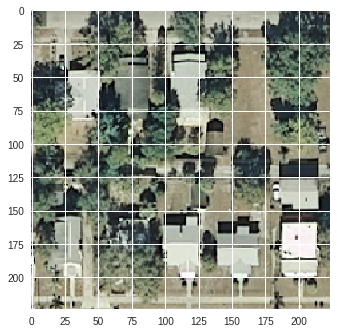

In [0]:
ds = dataset['val']
ix = random.randint(0, len(ds)-1)
img, label = ds[ix]
pred = net(img.unsqueeze(0).to(device)).squeeze()
pred_lab = torch.argmax(pred).item()
plt.imshow(img.numpy().transpose((1,2,0)))
img.shape, cats[label], cats[pred_lab]

# Save model

In [0]:
# save model

torch.save(net.cpu(), 'model.pth')

In [0]:
net = torch.load('model.pth')
net.to(device);